#Utilities

In [1]:
from globalVariable.global_variable import *

## Import

In [2]:
"""import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, LSTM,GRU, Dense,Bidirectional,Dropout,Activation, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K

import string
import pickle
import numpy as np
import os
import math

import matplotlib.pyplot as plt
import nltk

from attention import Attention
import string
"""

'import tensorflow as tf\nfrom tensorflow.keras.layers import Layer, Embedding, LSTM,GRU, Dense,Bidirectional,Dropout,Activation, Input\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.optimizers import Adam,RMSprop\nfrom tensorflow.keras.preprocessing.text import Tokenizer\nfrom tensorflow.keras import backend as K\n\nimport string\nimport pickle\nimport numpy as np\nimport os\nimport math\n\nimport matplotlib.pyplot as plt\nimport nltk\n\nfrom attention import Attention\nimport string\n'

In [3]:
#@title Install flower simulation
#!pip install flwr["simulation"]==0.18.0 

## Global Variable 

In [4]:
#@title Example form fields
#@markdown Forms support many types of fields.
dir = True  #@param {type: "boolean"}
make_test = False #@param {type: "boolean"}
shuffle_line = True  #@param {type: "boolean"}
percentage_of_line = 1 #@param {type:"slider", min:0, max:1, step:0.01}
path = r"dataset\en_US\short\short_tweet.txt"  #r"C:\Users\Giuli\Documents\tesi\federeted\dataset\book"  #@param ['/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/dataset/en/en_US.twitter.txt', '/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/dataset/The_Adventures_of_Sherlock_Holmes.txt', '/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/dataset', 'thursday']
token_path="/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/tokenization/tokenizer1.pkl"
checkpoint_path="/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/saved_model/nextword1.h5"

emending_length=50  #@param {type: "integer"}

lengt_sequence=3 #@param {type:"slider", min:1, max:10, step:1}
NUM_CLIENTS = 162 #@param {type:"slider", min:0, max:200, step:1}

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Function

In [6]:
@tf.autograph.experimental.do_not_convert
def perplexity(y_true, y_pred):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    cross_entropy = tf.keras.backend.categorical_crossentropy(y_true, y_pred)
    perplexity = tf.keras.backend.pow(2.0, cross_entropy)
    return perplexity

@tf.autograph.experimental.do_not_convert
def crossentropy(y_true, y_pred):
    return tf.keras.backend.categorical_crossentropy(y_true, y_pred)

class attentions(Layer):
    def init(self):
        super(attentions,self).__init__()
    def build(self,input_shape):
        self.W=self.add_weight(name='att_weight',shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name='att_bias',shape=(input_shape[-2],1),initializer="zeros")        
        super(attentions, self).build(input_shape)
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)

# Preprocessing

## Load File

In [7]:
lines=[]
if dir:
  with open(path, 'r', encoding = "utf8") as file:
    print(file)
    for i in file:
      lines.append(i)
    print(len(lines))
else:
  for filename in os.listdir(path):
    if filename.endswith(".txt"):
      print(filename)
      with open(os.path.join(path, filename), 'r', encoding = "utf8") as file:
        print(file)
        for i in file:
          lines.append(i)
        print(len(lines))

<_io.TextIOWrapper name='dataset\\en_US\\short\\short_tweet.txt' mode='r' encoding='utf8'>
19923


In [8]:
if shuffle_line:
  import random
  random.shuffle(lines)

### Print example

In [9]:
print("The First Line: ", lines[1])
print("The Last Line: ", lines[-1])

The First Line:  I don't know where to run

The Last Line:  I cannot even imagine how amazing photos of you in the Burlesque Corset And Petticoat would look. Photoaddict till the end.



## Tokenization

In [10]:
lines=lines[:int(len(lines)*percentage_of_line)]
print("count number of line: " + str(len(lines)) )
data = ' '. join(lines)
data=data.lower()
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace("—£","").replace("œuvre","").replace("—","").replace('‘',"").replace('’',"").replace( '£',"").replace('“',"").replace('”',"")

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space

data = data.translate(translator)

data[:360]

count number of line: 19923


'i did too   high five  i don t know where to run i love that video soo much its hillarious    especially when he stalks the goose lmfao rt   currently in tulsa  a few clouds and 88° so long as you re getting your money s worth  there is much gym going in your near future i predict on the floor rolling  cc insurance provider  15 000 in medical expenses  that '

In [11]:
tokens = nltk.wordpunct_tokenize(data)

In [12]:
tokens[:15]

['i',
 'did',
 'too',
 'high',
 'five',
 'i',
 'don',
 't',
 'know',
 'where',
 'to',
 'run',
 'i',
 'love',
 'that']

In [13]:
words = [w.lower() for w in tokens]

In [14]:
words[:15]

['i',
 'did',
 'too',
 'high',
 'five',
 'i',
 'don',
 't',
 'know',
 'where',
 'to',
 'run',
 'i',
 'love',
 'that']

In [15]:
vocab = sorted(set(words))
vocab_dict = dict() 
vocab_dic_reverse = dict()
for index,value in enumerate(vocab):
  vocab_dict[value] = index
  vocab_dic_reverse[index] = value
  
list(vocab_dict)[-50:]

['😂😂👍👍',
 '😂😂😂',
 '😂😂😂👎',
 '😃',
 '😄',
 '😉',
 '😊',
 '😊☺😁',
 '😊❤',
 '😊😘',
 '😌',
 '😍',
 '😍😘💏💑💋💍',
 '😏',
 '😒',
 '😒👎',
 '😒😞😔',
 '😓',
 '😔',
 '😖😰💔💔',
 '😘',
 '😘😘😘',
 '😚',
 '😜',
 '😜😁',
 '😝💗👍',
 '😞',
 '😠',
 '😡',
 '😡🔥',
 '😡😁',
 '😡😡',
 '😢',
 '😢💔',
 '😣👎',
 '😣🔫',
 '😥',
 '😭💣🔫',
 '😭😭😭',
 '😭😭😭😭',
 '😭😭😭😭😭😭',
 '😰',
 '😱',
 '😲',
 '😳',
 '😳😷',
 '😷',
 '😷😨',
 '🙌',
 '🚭']

In [16]:
vocab_dic_reverse[500] 

'447'

In [17]:
vocab_size=len(vocab_dict)
vocab_size

22648

In [18]:
def convert_int_text(prev,next,vocab_inv):
  r = ''
  for i in prev:
    r = r + vocab_inv[i] + " "
  r = r + vocab_inv[next]
  return r

## Create sequence

In [19]:
X=[]
y=[]
sequences=[]
for i in range(len(words)-lengt_sequence):
  sequence = []
  for j in range(lengt_sequence+1):
    sequence.append(vocab_dict[words[i+j]])
  sequences.append(sequence)

np.random.shuffle(sequences)
for sequence in sequences:
  X.append(sequence[:-1])
  y.append(sequence[-1])
X = np.array(X)
y = np.array(y)

In [20]:
len(sequences)

260951

In [21]:
print(X[0], end=' => ')
print(y[0])
print(convert_int_text(X[0],y[0],vocab_dic_reverse))

[19421 21414 20118] => 17501
t wait to see


# Model

In [22]:
embeddings_index = dict()
f = open(r"C:\Users\Giuli\Documents\tesi\federeted\embended\glove.6B.50d.txt", encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [23]:

embedding_matrix = np.zeros((vocab_size, emending_length))

for i, word in enumerate(list(vocab_dict)):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Sequential

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, emending_length, input_length=lengt_sequence,weights=[embedding_matrix],trainable=True))
model.add(LSTM(50, return_sequences=True))
model.add(Attention(units=25))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 50)             1132400   
                                                                 
 lstm (LSTM)                 (None, 3, 50)             20200     
                                                                 
 attention (Attention)       (None, 25)                5000      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 16)                416       
                                                                 
 dense_1 (Dense)             (None, 22648)             385016    
                                                                 
Total params: 1,543,032
Trainable params: 1,543,032
Non-

## callbacks

In [26]:
checkpoint_path="/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/saved_model/nextword1.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto')

reduce_l = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
#tensorboard_Visualization = TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_top3', patience=7, verbose=1,  mode="max")
top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=3, name='top3', dtype=None
)

In [27]:
@tf.autograph.experimental.do_not_convert
def pp(y_true, y_pred):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = tf.pow(tf.constant([2.0]),-1*cross_entropy)
    return perplexity

In [28]:
optimizer=Adam(learning_rate=0.001) #tf.keras.optimizers.RMSprop()#
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',top_k,pp])

In [29]:
batch_size= pow(2,8)
print(batch_size)
history = model.fit(X, y, validation_split=0.03, epochs=5, batch_size=batch_size,callbacks=[early_stop,reduce_l],shuffle=True)

256
Epoch 1/5
989/989 [==============================] - 31s 19ms/step - loss: 7.4134 - accuracy: 0.0314 - top3: 0.0834 - pp: 0.0197 - val_loss: 7.1845 - val_accuracy: 0.0405 - val_top3: 0.0906 - val_pp: 0.0223 - lr: 0.0010
Epoch 2/5
989/989 [==============================] - 18s 19ms/step - loss: 6.9643 - accuracy: 0.0481 - top3: 0.1049 - pp: 0.0281 - val_loss: 6.9998 - val_accuracy: 0.0636 - val_top3: 0.1242 - val_pp: 0.0312 - lr: 0.0010
Epoch 3/5
989/989 [==============================] - 18s 19ms/step - loss: 6.7401 - accuracy: 0.0686 - top3: 0.1330 - pp: 0.0380 - val_loss: 6.9088 - val_accuracy: 0.0812 - val_top3: 0.1463 - val_pp: 0.0420 - lr: 0.0010
Epoch 4/5
989/989 [==============================] - 18s 19ms/step - loss: 6.5798 - accuracy: 0.0818 - top3: 0.1525 - pp: 0.0455 - val_loss: 6.8755 - val_accuracy: 0.0874 - val_top3: 0.1540 - val_pp: 0.0454 - lr: 0.0010
Epoch 5/5
989/989 [==============================] - 18s 19ms/step - loss: 6.4669 - accuracy: 0.0887 - top3: 0.1626 

## plot the result


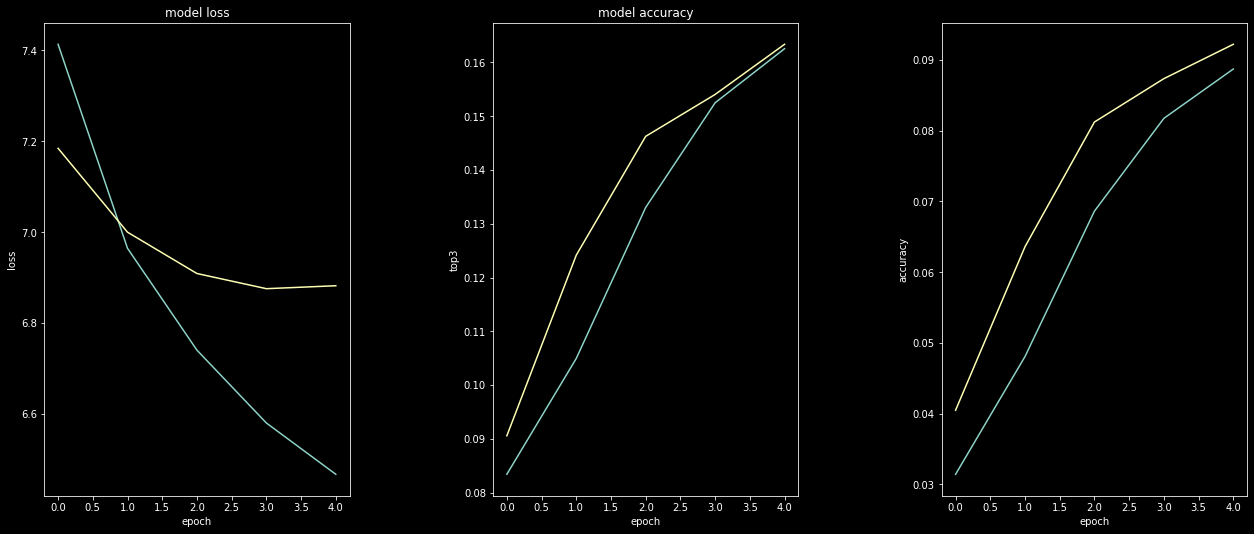

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
ax[0].plot(history.history['loss'])
ax[1].plot(history.history['top3'])
ax[2].plot(history.history['accuracy'])
ax[0].plot(history.history['val_loss'])
ax[1].plot(history.history['val_top3'])
ax[2].plot(history.history['val_accuracy'])
ax[0].set_title('model loss')
ax[1].set_title('model top3')
ax[1].set_title('model accuracy')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].set_ylabel('top3')
ax[1].set_xlabel('epoch')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
fig.tight_layout(pad=10.0)
plt.show()

#test

In [31]:
# Importing the Libraries


# Load the model and tokenizer
#checkpoint_path="/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/saved_model/nextword1.h5"

"""model = load_model(checkpoint_path,custom_objects={"crossentropy": crossentropy, "perplexity":perplexity})
model.summary
tokenizer = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/dataset/tokenization/tokenizer1.pkl", 'rb'))
"""

'model = load_model(checkpoint_path,custom_objects={"crossentropy": crossentropy, "perplexity":perplexity})\nmodel.summary\ntokenizer = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/tesi/next_word_prediction/dataset/tokenization/tokenizer1.pkl", \'rb\'))\n'

In [32]:
def Predict_Next_3_Words(model, tokenizer, text):
    """
        In this function we are using the tokenizer and models trained
        and we are creating the sequence of the text entered and then
        using our model to predict and return the the predicted word.
    
    """
    sequence = tokenizer.texts_to_sequences([text])
    sequence[0] = sequence[0][-lengt_sequence:]
    if len(sequence[0]) < lengt_sequence:
      return "no resutl"
    sequence = sequence[-lengt_sequence:]

    for i in range(3):
      print("i am thinking . . .")
      preds = model.predict(sequence)
      predicted_word=""
      pred_l=preds[0]
      ind = np.argpartition(pred_l, -3)[-3:]
      pred_l = ind[np.argsort(pred_l[ind])]
      pred_l = np.flip(pred_l, axis=None)
      result = []
      for ind in pred_l:
        print(preds[0][ind])
        predict = list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(ind)]
        result.append(predict)
      return result

In [33]:
"""text1 = "i love to"
text = text1.split(" ")
sequence = tokenizer.texts_to_sequences([text])
sequence[0] = sequence[0][-lengt_sequence:]
sequence = sequence[-lengt_sequence:]
preds = model.predict(sequence)
pred_l=preds[0]
ind = np.argpartition(pred_l, -3)[-3:]
print(ind)
print(pred_l[1])
print(ind[np.argsort(pred_l[ind])])
pred_l = ind[np.argsort(pred_l[ind])]
pred_l = np.flip(pred_l, axis=None)
result = []

for ind in pred_l:
  print(preds[0][ind])
  predict = list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(ind)]
  result.append(predict)
print(result)
p=Predict_Next_3_Words(model, tokenizer, text)"""

'text1 = "i love to"\ntext = text1.split(" ")\nsequence = tokenizer.texts_to_sequences([text])\nsequence[0] = sequence[0][-lengt_sequence:]\nsequence = sequence[-lengt_sequence:]\npreds = model.predict(sequence)\npred_l=preds[0]\nind = np.argpartition(pred_l, -3)[-3:]\nprint(ind)\nprint(pred_l[1])\nprint(ind[np.argsort(pred_l[ind])])\npred_l = ind[np.argsort(pred_l[ind])]\npred_l = np.flip(pred_l, axis=None)\nresult = []\n\nfor ind in pred_l:\n  print(preds[0][ind])\n  predict = list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(ind)]\n  result.append(predict)\nprint(result)\np=Predict_Next_3_Words(model, tokenizer, text)'

In [34]:

"""
while(make_test):

    text = input("Enter your line: ")
    
    if text == "stop":
        print("Ending The Program.....")
        break
    
    else:
        try:
            text = text.split(" ")
            p=Predict_Next_3_Words(model, tokenizer, text)
            print(p)
        except NameError:
            print(NameError)
            continue"""

'\nwhile(make_test):\n\n    text = input("Enter your line: ")\n    \n    if text == "stop":\n        print("Ending The Program.....")\n        break\n    \n    else:\n        try:\n            text = text.split(" ")\n            p=Predict_Next_3_Words(model, tokenizer, text)\n            print(p)\n        except NameError:\n            print(NameError)\n            continue'

# Fedeteretd simulate

## Import

In [35]:

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# Create client fr flower 

In [36]:
class NextWordPredictionClient(fl.client.NumPyClient):
    def __init__(self, model_f, x_train, y_train, x_val, y_val) -> None:
      self.model_f = model_f
      self.x_train, self.y_train = x_train, y_train
      self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model_f.get_weights()

    def fit(self, parameters, config):
        self.model_f.set_weights(parameters)
        self.model_f.fit(self.x_train,self.y_train, epochs=5, batch_size=64,verbose=2)
        return self.model_f.get_weights(), len(X), {}

    def evaluate(self, parameters, config):
        self.model_f.set_weights(parameters)
        loss, accuracy,top_3 = self.model_f.evaluate(self.x_val, self.y_val,verbose=2)
        return loss, len(self.x_val), {"val_loss": loss, "val_accuracy":accuracy , "val_top_3": top_3}


## Implementation

In [37]:
np.random.shuffle(sequences)

In [38]:
def client_fn(cid: str) -> fl.client.Client:
  # Create model

  top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(
      k=3, name='top3', dtype=None
  )
  model = Sequential()
  model.add(Embedding(vocab_size, emending_length, input_length=lengt_sequence,weights=[embedding_matrix],trainable=True))
  model.add(LSTM(50, return_sequences=True))
  model.add(Attention(units=25))
  model.add(Dropout(0.3))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))
  
  optimizer=Adam(learning_rate=0.001) #tf.keras.optimizers.RMSprop()#
  model.compile(loss=perplexity, optimizer=optimizer, metrics=['accuracy',top_k])
  
  partition_size = math.floor(len(sequences) / (NUM_CLIENTS+1))
  idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size

  X_f = []
  y_f = []

  for i in sequences[idx_from: idx_to]:
      X_f.append(i[0:lengt_sequence])
      y_f.append(i[-1])
      
  X_f = np.array(X_f)
  y_f = np.array(y_f)


  # Use 10% of the client's training data for validation
  split_idx = math.floor(len(X_f) * 0.9)
  x_train_cid, y_train_cid = X_f[:split_idx], y_f[:split_idx]
  x_val_cid, y_val_cid = X_f[split_idx:], y_f[split_idx:]
  # Create and return client
  return NextWordPredictionClient(model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

In [39]:
def get_eval_fn(model):
    """Return an evaluation function for server-side evaluation."""

    def get_data():
      partition_size = math.floor(len(sequences) / (NUM_CLIENTS+1))
      idx_from, idx_to =  (NUM_CLIENTS+1) * partition_size, (NUM_CLIENTS+2) * partition_size

      X_f = []
      y_f = []

      for i in sequences[idx_from: idx_to]:
          X_f.append(i[0:lengt_sequence])
          y_f.append(i[-1])
          
      X_f = np.array(X_f)
      y_f = np.array(y_f)
      return X_f,y_f

    # The `evaluate` function will be called after every round
    def evaluate(weights: fl.common.Weights):
        model.set_weights(weights)  # Update model with the latest parameters
        x_val, y_val = get_data()
        loss, accuracy,top_3 = model.evaluate(x_val, y_val,verbose=2)
        return loss, { "loss":loss,"val_accuracy":accuracy , "val_top_3": top_3}


    return evaluate

In [40]:
class AggregateCustomMetricStrategy(fl.server.strategy.FedAvg):
    def aggregate_evaluate(
        self,
        rnd: int,
        results,
        failures,
    ) :
        """Aggregate evaluation losses using weighted average."""
        if not results:
            return None
        
        loss,_ = super().aggregate_evaluate(rnd, results, failures)

        # Weigh accuracy of each client by number of examples used
        accuracies = [r.metrics["val_accuracy"] * r.num_examples for _, r in results]
        top_k = [r.metrics["val_top_3"] * r.num_examples for _, r in results]
        examples = [r.num_examples for _, r in results]

        # Aggregate and print custom metric
        accuracy_aggregated = sum(accuracies) / sum(examples)
        top_k_grragated = sum(top_k) / sum(examples)
        print(f"Round {rnd} aggregated  from client results loss : {loss},accuracy : {accuracy_aggregated} , top_3: {top_k_grragated}")

        # Call aggregate_evaluate from base class (FedAvg)
        return loss, {"accuracy":accuracy_aggregated,"top_k":top_k_grragated}

In [41]:
#initial_parameters=model.get_weights()

strategy=AggregateCustomMetricStrategy(
        fraction_fit=0.05,  # Sample 10% of available clients for training
        fraction_eval=0.02,  # Sample 5% of available clients for evaluation
        min_fit_clients=2,  # Never sample less than 10 clients for training
        min_eval_clients=2,  # Never sample less than 5 clients for evaluation
        min_available_clients=int(NUM_CLIENTS * 0.75),  # Wait until at least 75 clients are available
        #initial_parameters=fl.common.weights_to_parameters(model.get_weights()),
        #fit_metrics_aggregation_fn =fit_metrics_aggregation_fn_custom
        #eval_fn=get_eval_fn(model)
)

In [42]:
import ray
history_fede=fl.simulation.start_simulation(
  client_fn=client_fn,
  num_clients=NUM_CLIENTS,
  strategy=strategy,
  num_rounds=40,
  ray_init_args={})

OSError: [Errno 0] AssignProcessToJobObject() failed

In [ ]:
ray.init()

OSError: [Errno 0] AssignProcessToJobObject() failed

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
ax[0].plot(*zip(*history_fede.losses_distributed))
ax[1].plot(*zip(*history_fede.metrics_distributed['top_k']))
ax[2].plot(*zip(*history_fede.metrics_distributed['accuracy']))
ax[0].set_title('model loss')
ax[1].set_title('model top3')
ax[2].set_title('model accuracy')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('round')
ax[1].set_ylabel('top3')
ax[1].set_xlabel('round')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('round')
fig.tight_layout(pad=10.0)
plt.show()